# NI-VSM 3.DÚ
---
Jan Peřina  & Zdena Tropková & Matěj Hoffmann

---

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from IPython.display import HTML, display
import plotly.io as pio

pd.options.plotting.backend = "plotly"

pio.renderers.default = "png"
plt.rcParams['figure.dpi'] = 500
pd.options.display.max_columns = 30

In [61]:
K = 30
L = len("Perina")
X = 1 + (K*L*23 % 20)
Y = (X + ((K*5 + L*7) % 19) % 20) + 1
xxx = f'{X:03d}.txt'
yyy = f'{Y:03d}.txt'
print(f"Budou použity soubory {xxx} a {yyy}")

Budou použity soubory 001.txt a 004.txt


## Načtení souborů

In [62]:
with open(f'../data/{xxx}', 'r') as f:
    f.readline()  # nadpis ignorujeme
    first = f.read()
    print(f'Délka prvního textu: {len(first)}')

with open(f'../data/{yyy}', 'r') as f:
    f.readline()
    second = f.read()
    print(f'Délka druhého textu: {len(second)}')

Délka prvního textu: 6458
Délka druhého textu: 5607


## Spočtení pravděpodobností

Pravděpodobnost spočteme jako počet výskytů daného znaku v textu děleno počtem znaků v textu, tedy jeho délky.

$$ \text{p}(x,t)= \frac{\# \text{ výskytů znaku }x\text{ v textu }t}{\# \text{ znaku v textu }t} $$

In [63]:
def count_letters(text):
    counts = {}

    for x in text:
        if x not in counts:
            counts[x] = 1
        else:
            counts[x] += 1

    df = pd.DataFrame.from_dict(counts, orient='index', columns=['counts'])
    df['freq'] = df['counts'] / len(text)
    df.sort_values(by=['freq'], ascending=False, inplace=True)
    df.index = df.index.rename('znak')

    return df

In [64]:
# první text
df_first = count_letters(first)
print(df_first[['counts']].T)

znak            e    a    t    o    n    r    h    d    i    s    l    u    g  \
counts  1199  659  438  436  399  355  350  337  303  297  291  249  159  141   

znak      f    w    m    c   b   p   y   k   v   j  q  z  x  
counts  137  117  109  102  96  91  83  52  30  15  6  6  1  


In [65]:
# druhý text
df_second = count_letters(second)
print(df_second[['counts']].T)

znak            e    t    a    o    h    n    i    r    s    d    l    u    f  \
counts  1029  577  409  384  355  316  310  307  295  284  209  173  129  129   

znak      c    w   g   m   p   y   b   v   k   j  q  z  x  
counts  124  117  94  80  72  60  55  37  30  13  8  7  4  


## Vizualizace pravděpodobností

Jednotlivé pravděpodobnosti nyní zobrazíme pomocí sloupcového grafu, osa y reprezentuje pravděpodobnost znaku v textu. Osa X je diskrétní a reprezentuje jednotlivé znaky seřazené od nejčetnějšího po ten nejméně četný.

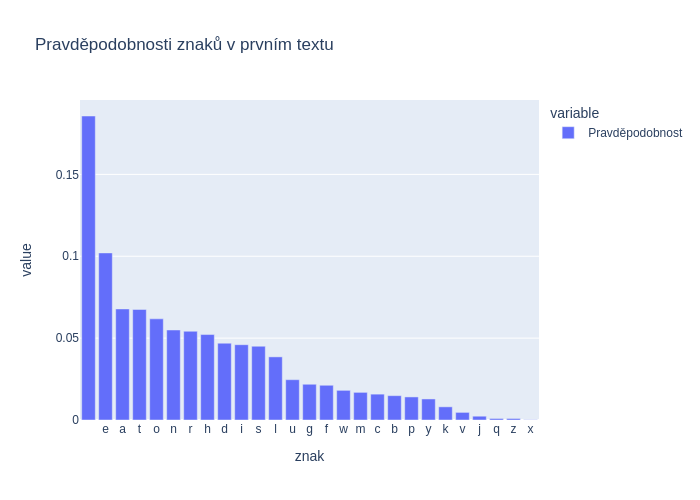

In [66]:
df_first['freq'].rename('Pravděpodobnost').plot(
    kind='bar', title="Pravděpodobnosti znaků v prvním textu")

Jak je vidět, tak znakem s největší pravděpodobností je mezera, následně znaky `e`, `a` a `t`. Nejméně pravděpodobné naopak byly znaky `q`, `z` a `x`.

Obdobně jsme zvizualizovali hodnoty pro druhý text.

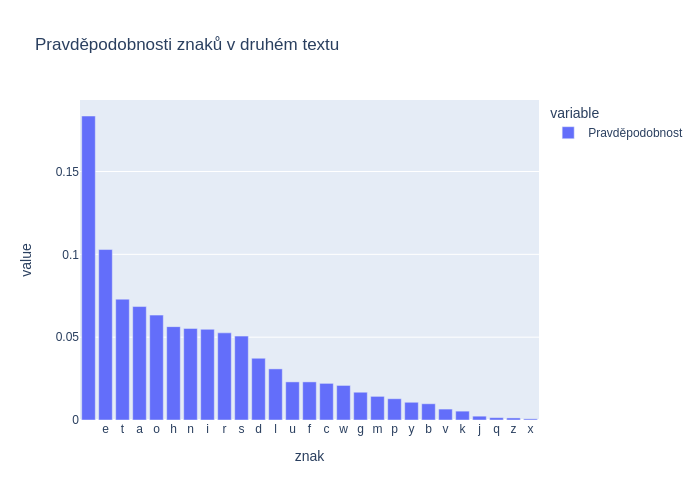

In [67]:
df_second['freq'].rename('Pravděpodobnost').plot(
    kind='bar', title="Pravděpodobnosti znaků v druhém textu")

Z grafu je vidět, že opět byla nejčastější mezera, hned po ní opět trojice `e`, `a`, `t` (v jiném pořadí) a nejméně četné byly opět znaky `q`,`z` a `x`.

Na základě této podobnosti jsme se rozhodli vykreslit graf pravděpodobností jednotlivých znaků pro oba texty. 

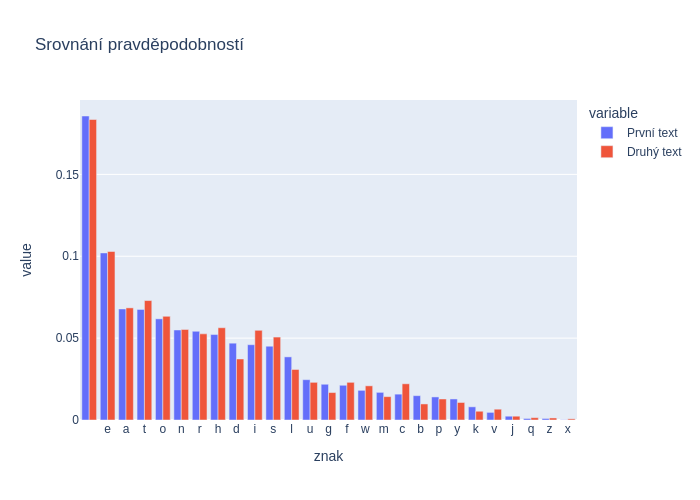

In [68]:
c = df_first[['freq']].join(df_second[['freq']], lsuffix='_f', rsuffix='_s')
c.columns = ['První text', 'Druhý text']
c.plot(kind='bar',title='Srovnání pravděpodobností', barmode="group")

Jak je vidět z grafu, sloupce pro oba texty jsou s menšími rozdíly velmi podobné. Rozhodli jsme se proto tedy spočíst korelaci mezi pravděpodobnostmi jednotlivých znaků.

#### Korelace pravděpodobností

In [69]:
df_first[['freq']].join(df_second[['freq']], lsuffix='_f', rsuffix='_s').corr().iloc[1, 0]

0.9945439587726614

Jak je vidět, tak pravděpodobnosti výskytů jednotlivých znaků v techtech je silně korelovaná.

## Matice přechodu


In [70]:
import plotly.express as px

def display_matrix(matrix, mapping, title=""):
    fig = px.imshow(matrix, x=mapping, y=mapping)

    fig.update_layout(title=title, margin = dict(t=200,r=200,b=200,l=200),
    
        showlegend = False,
        width = 800, height = 800,
        autosize = False )


    fig.show()

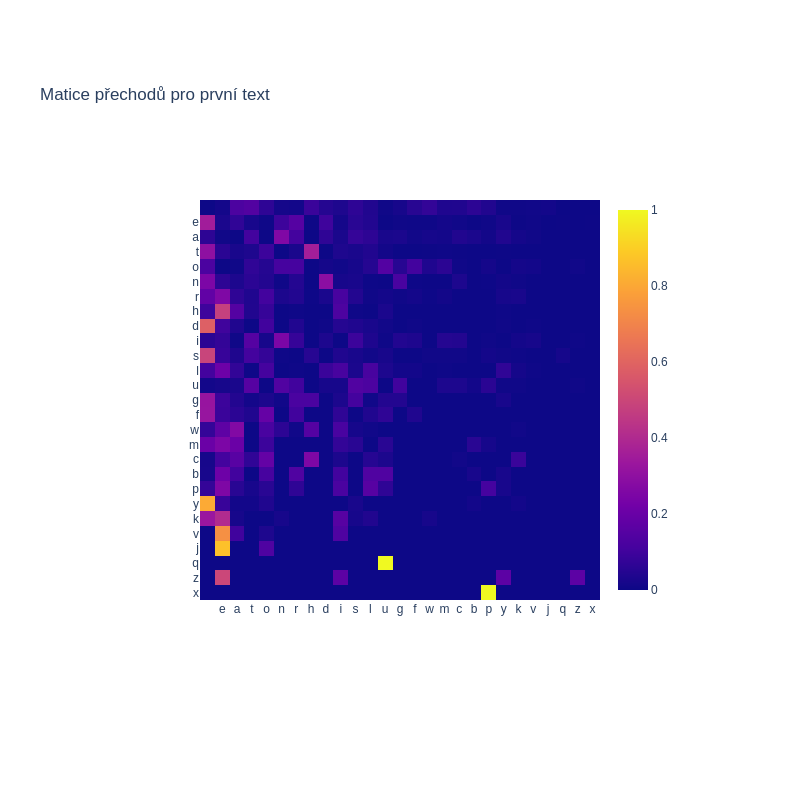

In [71]:
mapping = list(df_first.index.values)

inverse_mapping = {c:i for i,c in enumerate(mapping)}

A = np.zeros(shape=[len(mapping)]*2)

for i in range(len(first)-1):
    src = first[i]
    dest = first[i+1]
    A[inverse_mapping[src],inverse_mapping[dest]] += 1


A /= A.sum(axis=0)[:, None]

display_matrix(A, mapping, title="Matice přechodů pro první text")

In [72]:
sorted(filter( lambda x: x[0], [*zip(A[inverse_mapping['j']], mapping)]))

[(0.13333333333333333, 'o'), (0.8666666666666667, 'e')]

In [73]:
len([i for i in range(len(first)) if first[i:i+2]=='je']) / len([i for i in range(len(first)) if first[i]=='j'])



0.8666666666666667

 Je-li množina stavů S konečná, pak stacionární rozdělení existuje.


$$
\pi \cdot \mathbf{P} = \pi \\





$$

In [74]:
P_n = np.linalg.matrix_power(A, 10000000000000000000)
np.abs(P_n[0]- P_n[1])
row=P_n[0]

In [75]:
eigen_vals, eigen_vectors = np.linalg.eig(A.T) # transponovanim dostaneme prave vlastni vektory
eigen_vectors_1 = eigen_vectors[:, np.isclose(eigen_vals, 1)][:, 0] # vezmeme vektory odpovídající vl. č. blízkému 1

In [76]:
stationary = (eigen_vectors_1 / eigen_vectors_1.sum()).real
stationary

array([1.85689949e-01, 1.02059780e-01, 6.78333591e-02, 6.73687471e-02,
       6.17934025e-02, 5.49790925e-02, 5.42047390e-02, 5.21914202e-02,
       4.69258169e-02, 4.59965928e-02, 4.50673687e-02, 3.85628001e-02,
       2.46244386e-02, 2.18367663e-02, 2.12172836e-02, 1.81198699e-02,
       1.68809044e-02, 1.57968097e-02, 1.48675856e-02, 1.40932322e-02,
       1.28542667e-02, 8.05327551e-03, 4.64612049e-03, 2.32306024e-03,
       9.29224098e-04, 9.29224098e-04, 1.54870683e-04])

In [77]:
np.allclose(stationary.T @ A, stationary.T)

True

In [78]:
np.abs(stationary.T @ A - stationary.T).mean()

1.9248604125219502e-17

In [79]:
np.abs(row - stationary).sum()

3.7172151117593458e+25

In [80]:
np.allclose(row.T @ A, row.T)

True

In [81]:
stationary

array([1.85689949e-01, 1.02059780e-01, 6.78333591e-02, 6.73687471e-02,
       6.17934025e-02, 5.49790925e-02, 5.42047390e-02, 5.21914202e-02,
       4.69258169e-02, 4.59965928e-02, 4.50673687e-02, 3.85628001e-02,
       2.46244386e-02, 2.18367663e-02, 2.12172836e-02, 1.81198699e-02,
       1.68809044e-02, 1.57968097e-02, 1.48675856e-02, 1.40932322e-02,
       1.28542667e-02, 8.05327551e-03, 4.64612049e-03, 2.32306024e-03,
       9.29224098e-04, 9.29224098e-04, 1.54870683e-04])

Text(0.5, 1.0, 'Graficke srovnani stacionátního rozdělení prvního textu a pravděpodobností znaků druhého textu')

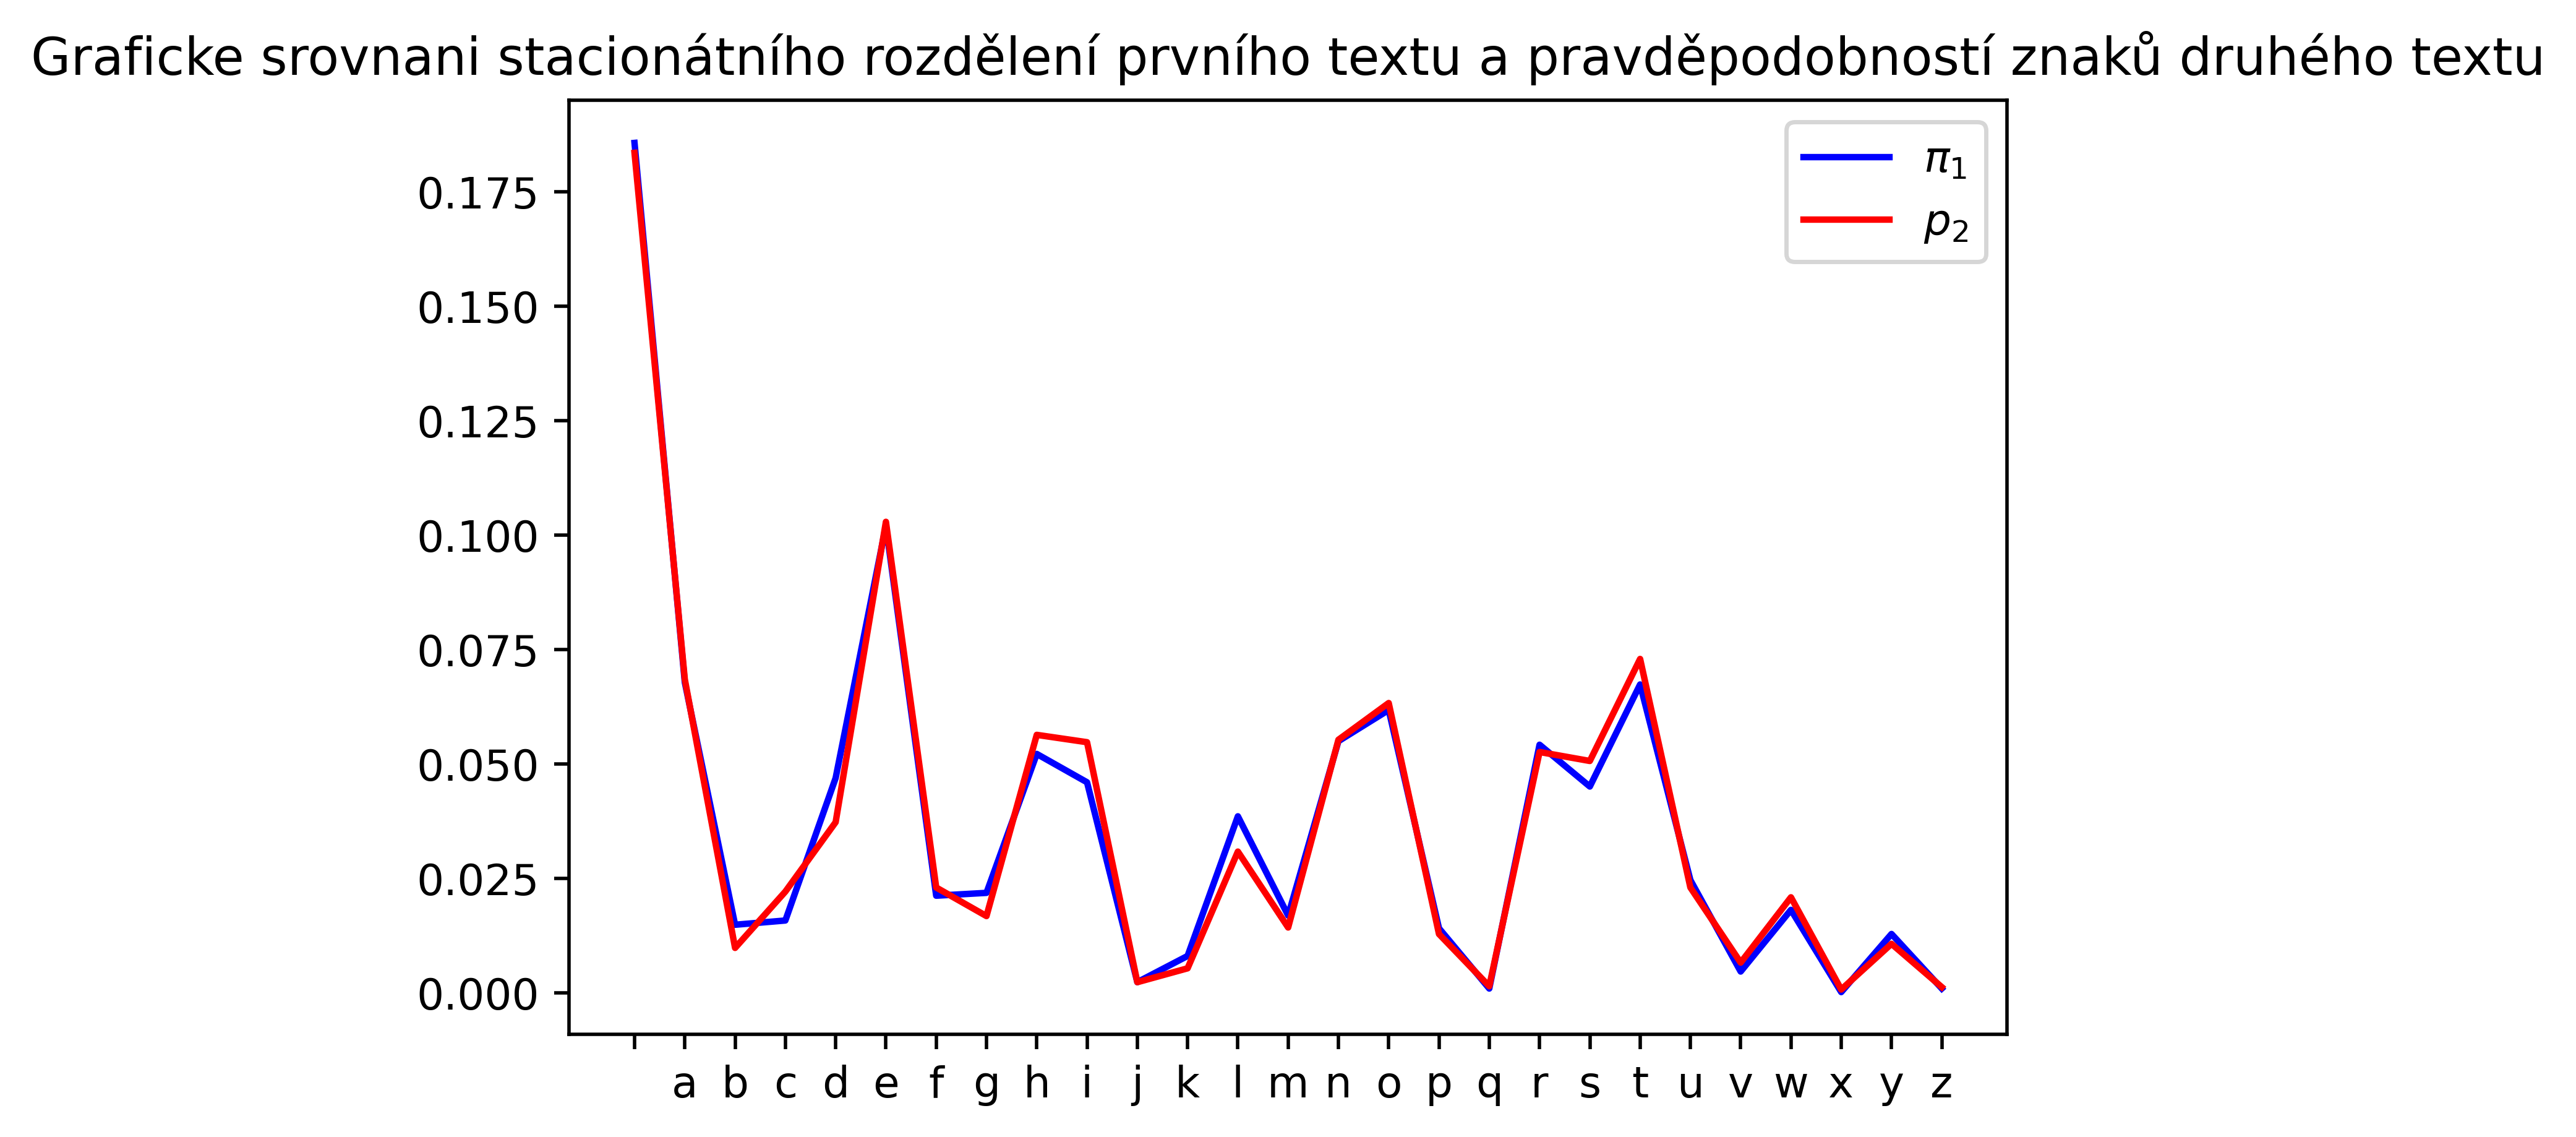

In [82]:
# mapping pro prvni a druhy nejsou stejne!
plt.plot(*zip(*sorted(zip(mapping, stationary))), color='b', label='$\pi_1$')
plt.plot(*zip(*sorted(zip(list(df_second.index), list(df_second['freq'])))), color='r', label='$p_2$')
# plt.plot(_[0])
plt.legend()
plt.title('Graficke srovnani stacionátního rozdělení prvního textu a pravděpodobností znaků druhého textu')

In [83]:
from scipy.stats import chi2_contingency
import scipy
print(f"Kritický obor: {scipy.stats.chi2.isf(0.05, 26)}")

chi2, p_value, dof, _ = chi2_contingency([[*zip(*sorted(zip(mapping, stationary)))][1], list(zip(*sorted(zip(list(df_second.index), list(df_second['freq'])))))[1]])
chi2, p_value, dof, _

Kritický obor: 38.88513865983007


(0.008439694295221505,
 1.0,
 26,
 array([[0.18460527, 0.06815959, 0.01233838, 0.01895601, 0.04210033,
         0.10248343, 0.02211212, 0.01930076, 0.05427477, 0.05037479,
         0.0023208 , 0.00670187, 0.03470854, 0.01557439, 0.05513356,
         0.06255356, 0.01346716, 0.00117801, 0.05340877, 0.04785917,
         0.07015664, 0.0238157 , 0.00562251, 0.01949332, 0.00043413,
         0.01177759, 0.00108883],
        [0.18460527, 0.06815959, 0.01233838, 0.01895601, 0.04210033,
         0.10248343, 0.02211212, 0.01930076, 0.05427477, 0.05037479,
         0.0023208 , 0.00670187, 0.03470854, 0.01557439, 0.05513356,
         0.06255356, 0.01346716, 0.00117801, 0.05340877, 0.04785917,
         0.07015664, 0.0238157 , 0.00562251, 0.01949332, 0.00043413,
         0.01177759, 0.00108883]]))